In [1]:
import numpy as np
import pandas as pd
import os

from collections import defaultdict, Counter

import tensorflow as tf
from tensorflow import keras

from datetime import datetime
import time

from keras.layers.experimental import preprocessing
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, Input, Dense, Flatten
from keras.models import Sequential
from keras.callbacks import History 


from keras.utils import to_categorical
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score


import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#%pdb

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Load Dataset

https://physionet.org/content/mitdb/1.0.0/

Background

Since 1975, our laboratories at Boston's Beth Israel Hospital (now the Beth Israel Deaconess Medical Center) and at MIT have supported our own research into arrhythmia analysis and related subjects. One of the first major products of that effort was the MIT-BIH Arrhythmia Database, which we completed and began distributing in 1980. The database was the first generally available set of standard test material for evaluation of arrhythmia detectors, and has been used for that purpose as well as for basic research into cardiac dynamics at more than 500 sites worldwide. Originally, we distributed the database on 9-track half-inch digital tape at 800 and 1600 bpi, and on quarter-inch IRIG-format FM analog tape. In August, 1989, we produced a CD-ROM version of the database.

Data Description

The MIT-BIH Arrhythmia Database contains 48 half-hour excerpts of two-channel ambulatory ECG recordings, obtained from 47 subjects studied by the BIH Arrhythmia Laboratory between 1975 and 1979. Twenty-three recordings were chosen at random from a set of 4000 24-hour ambulatory ECG recordings collected from a mixed population of inpatients (about 60%) and outpatients (about 40%) at Boston's Beth Israel Hospital; the remaining 25 recordings were selected from the same set to include less common but clinically significant arrhythmias that would not be well-represented in a small random sample.

The recordings were digitized at 360 samples per second per channel with 11-bit resolution over a 10 mV range. Two or more cardiologists independently annotated each record; disagreements were resolved to obtain the computer-readable reference annotations for each beat (approximately 110,000 annotations in all) included with the database.

In [3]:
# Load Triaining and Testing Datasets
# Local
file_path = '../mitbihcsv'
#Paperspace
#file_path = '/storage/data/mit-bih'

file_name = 'mit_bih_data_set.csv'
dataset_path = os.path.join(file_path,file_name)
data_set = pd.read_csv(dataset_path,dtype=float)
num_classes=6
data_set_np = data_set.to_numpy()
X = data_set_np[:,:-1].astype('float32')
y = data_set_np[:,-1]


In [4]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

y_trn_oh = to_categorical(y_trn)
y_tst_oh = to_categorical(y_tst)

X_trn_tf = np.expand_dims(X_trn, axis=2)
X_tst_tf = np.expand_dims(X_tst, axis=2)


#X_tst = X_tst.astype('float32')
#X_tst_tf = X_tst_tf.astype('float32')

## 3. Training a 1D Convolutional Neural Network

In [5]:
epochs = 100
batch_size = 500
validation_split = 0.2 # 20% of training set will be used for validation set. 

model = Sequential()

model.add(Conv1D(16, 8, activation='relu', padding="same",
                 input_shape=X_trn_tf[1,:].shape,
                 name='Conv1DLayer1'))
model.add(MaxPooling1D(4, padding='same'))
    
model.add(Conv1D(16, 8, activation='relu', padding="same", name='Conv1DLayer2'))
model.add(MaxPooling1D(4, padding='same'))
    
model.add(Conv1D(16, 16, activation='relu', padding="same", name='Conv1DLayer3'))

model.add(Flatten())

model.add(Dense(num_classes, activation='softmax', name = 'OuputLayer'))

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,
                                                             decay_steps=1000,decay_rate=0.9)

opt = RMSprop(learning_rate=lr_schedule)

model.compile(loss='categorical_crossentropy', optimizer=opt, 
              metrics=['accuracy'])

#logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

#tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
#                                                 histogram_freq = 1,
#                                                 profile_batch = '30,80')


callbacks = [EarlyStopping(monitor='val_loss', patience=50),
             ModelCheckpoint(filepath='./base_model.h5', 
                             monitor='val_accuracy', save_best_only=True)]
             #, tboard_callback]

# fit network
history=model.fit(X_trn_tf, y_trn_oh, epochs=epochs,callbacks=callbacks, 
                  batch_size=batch_size,validation_split=validation_split)

model.load_weights('base_model.h5')

train_score = model.evaluate(X_trn_tf, y_trn_oh)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(X_tst_tf, y_tst_oh)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Epoch 1/100
54/54 [==============================] - 16s 112ms/step - loss: 1.1971 - accuracy: 0.5573 - val_loss: 0.1174 - val_accuracy: 0.9664
Epoch 2/100
54/54 [==============================] - 2s 33ms/step - loss: 0.1574 - accuracy: 0.9563 - val_loss: 0.0990 - val_accuracy: 0.9725
Epoch 3/100
54/54 [==============================] - 2s 33ms/step - loss: 0.0820 - accuracy: 0.9775 - val_loss: 0.0560 - val_accuracy: 0.9868
Epoch 4/100
54/54 [==============================] - 2s 33ms/step - loss: 0.0612 - accuracy: 0.9831 - val_loss: 0.0453 - val_accuracy: 0.9878
Epoch 5/100
54/54 [==============================] - 2s 34ms/step - loss: 0.0395 - accuracy: 0.9893 - val_loss: 0.1072 - val_accuracy: 0.9659
Epoch 6/100
54/54 [==============================] - 2s 33ms/step - loss: 0.0405 - accuracy: 0.9876 - val_loss: 0.0385 - val_accuracy: 0.9897
Epoch 7/100
54/54 [==============================] - 2s 33ms/step - loss: 0.0330 - accuracy: 0.9911 - val_loss: 0.0452 - val_accuracy: 0.9885
Epoc

# Load the TensorBoard notebook extension.
%load_ext tensorboard

# Launch TensorBoard and navigate to the Profile tab to view performance profile
%tensorboard --logdir=logs

In [6]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4','5']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [7]:
print(tf.config.experimental.get_memory_usage("GPU:0"))

82176


Accuracy: 99.19%


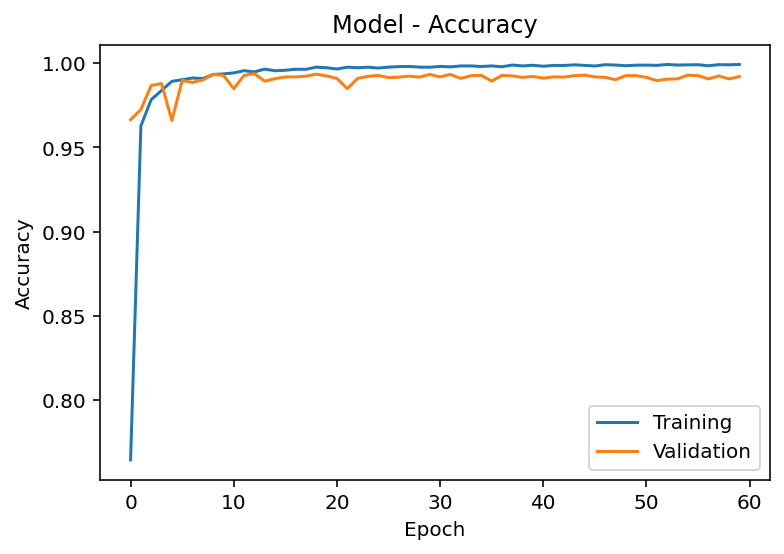

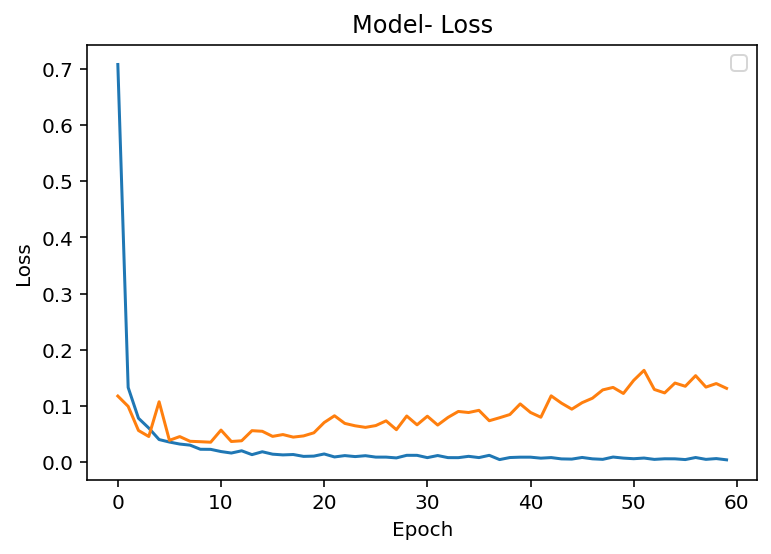

Wall time: 4.12 s


In [8]:
%%time
evaluate_model(history,X_tst_tf,y_tst_oh,model)
y_pred=model.predict(X_tst_tf)

In [9]:
with tf.device('/cpu:0'):
    start = time.time()
    model.predict(X_tst_tf)
    end = time.time()

inference_time =  (end-start)/X_tst_tf.shape[0]
throughput = X_tst_tf.shape[0]/(end-start)

print("Inference on CPU is :", inference_time)
print("Throughput on CPU is :", throughput, "sequence per second")

Inference on CPU is : 0.0002274764032377509
Throughput on CPU is : 4396.060363917539 sequence per second


In [10]:
with tf.device('/gpu:0'):
    start = time.time()
    model.predict(X_tst_tf)
    end = time.time()

inference_time =  (end-start)/X_tst_tf.shape[0]
throughput = X_tst_tf.shape[0]/(end-start)

print("Inference on GPU is :", inference_time)
print("Throughput on GPU is :", throughput, "sequence per second")

Inference on GPU is : 0.00011982927998720266
Throughput on GPU is : 8345.20578031343 sequence per second


Normalized confusion matrix


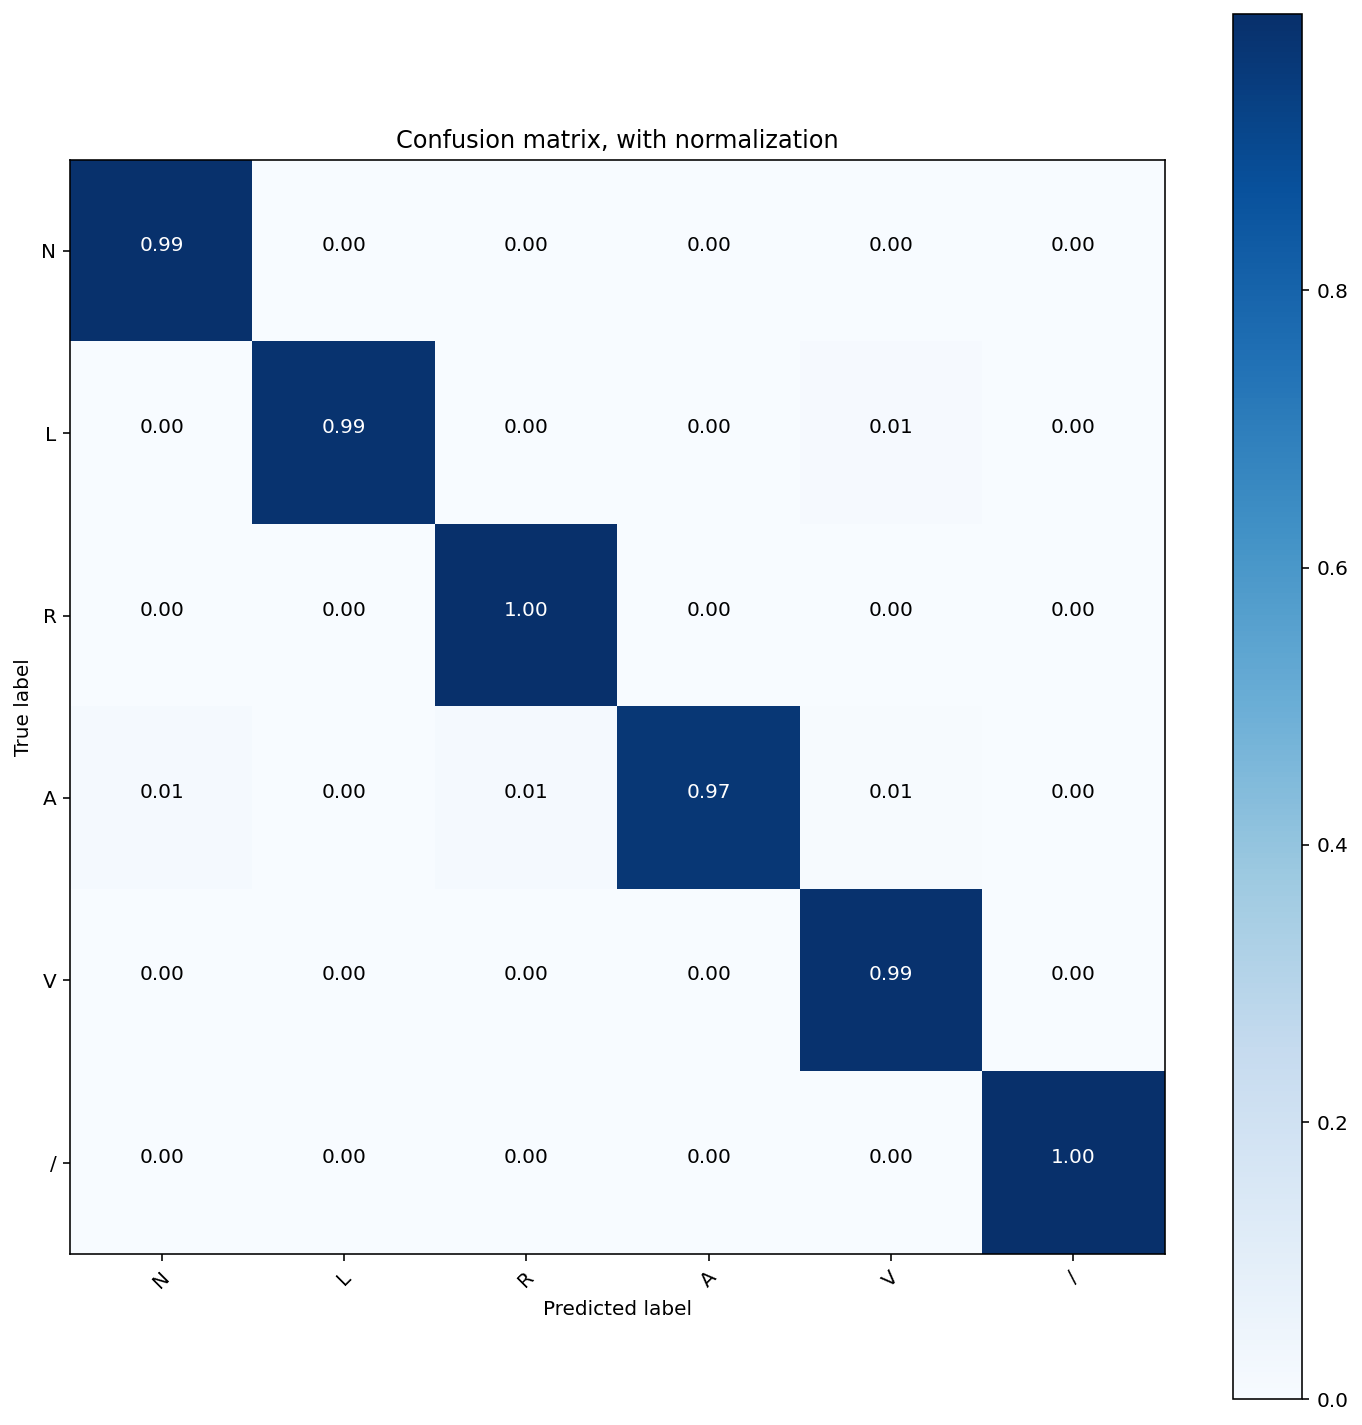

In [11]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_tst_oh.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'L', 'R', 'A', 'V', '/'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()    

Accuracy: 0.9919086149452642


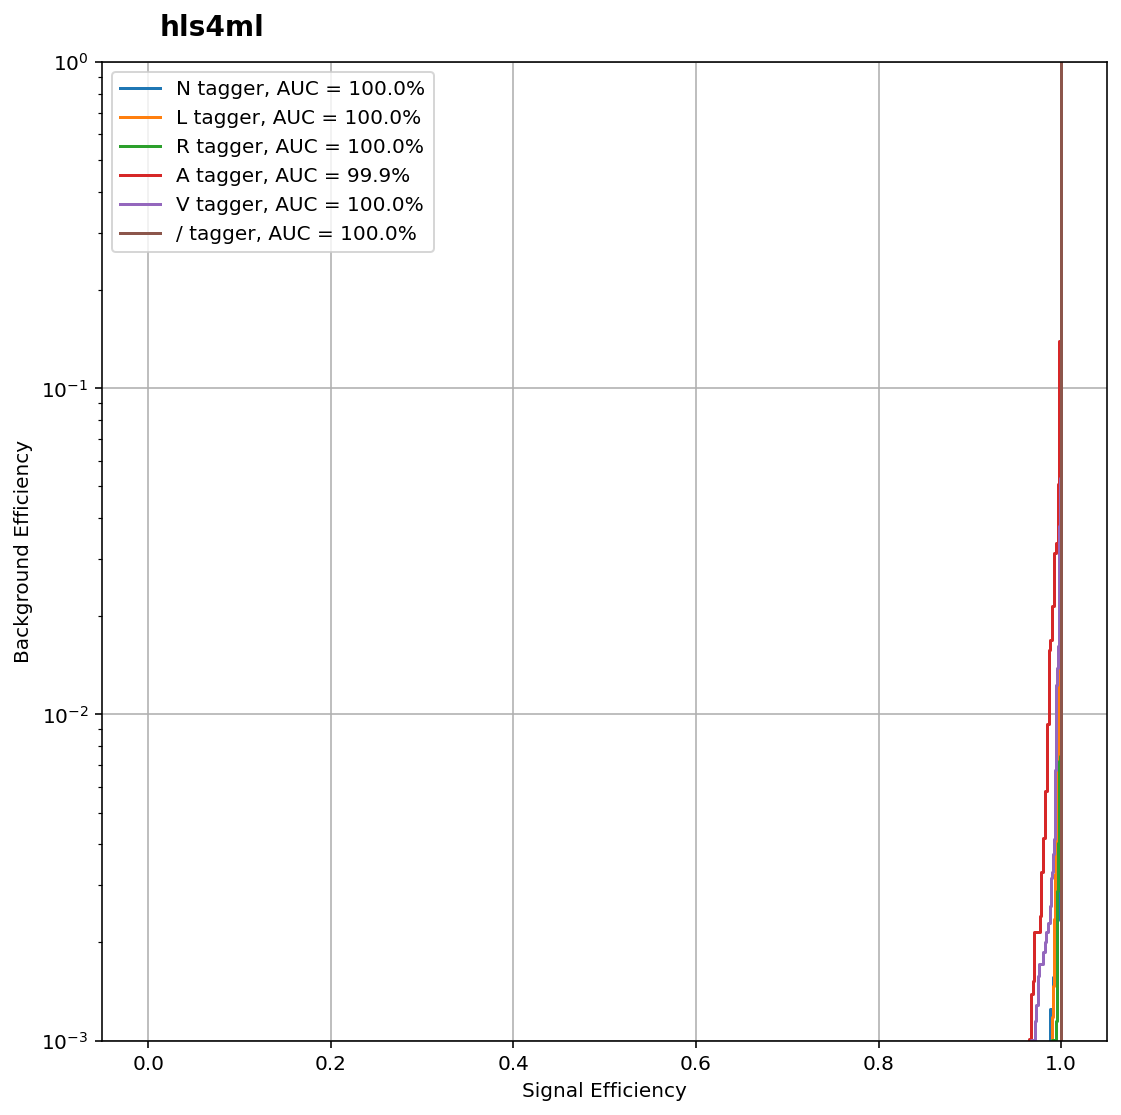

In [12]:
import plotting

classes = ['N', 'L', 'R', 'A', 'V', '/']

y_keras = model.predict(X_tst_tf)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_tst_oh, axis=1), np.argmax(y_keras, axis=1))))
plt.figure(figsize=(9,9))
_ = plotting.makeRoc(y_tst_oh, y_keras, classes)

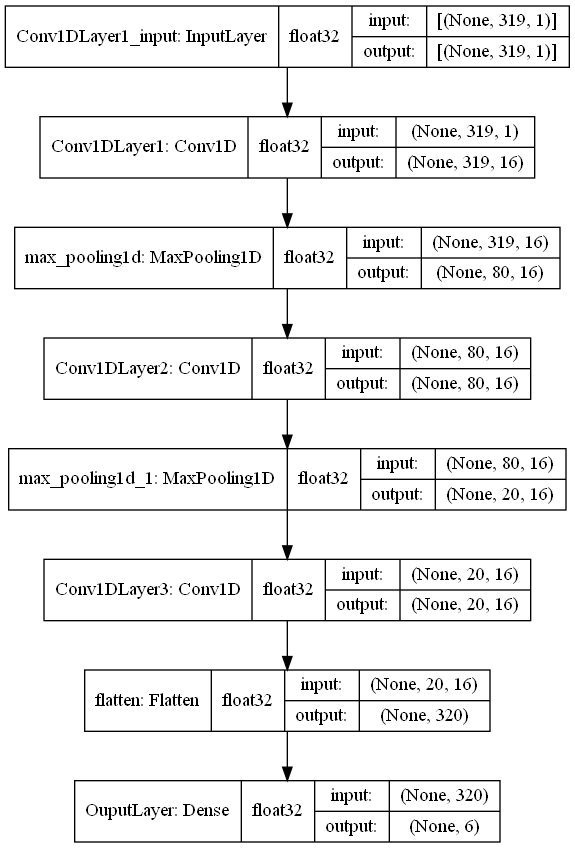

In [13]:
from keras.utils import plot_model
plot_model(model,show_shapes=True, show_dtype=True)
#tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [14]:
#!pip install tf_agents==0.7.1
#!pip install tensorflow_probability==0.12.2

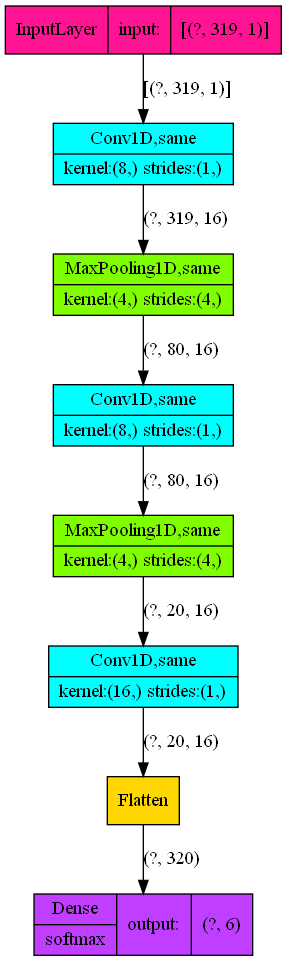

In [15]:
from plot_model import plot_model
plot_model(model,to_file='base_model.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, style=0, color=True, dpi=96)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1DLayer1 (Conv1D)        (None, 319, 16)           144       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 80, 16)            0         
_________________________________________________________________
Conv1DLayer2 (Conv1D)        (None, 80, 16)            2064      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 16)            0         
_________________________________________________________________
Conv1DLayer3 (Conv1D)        (None, 20, 16)            4112      
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
OuputLayer (Dense)           (None, 6)                 1

# Tensorflow Optimization Toolkit does not support Conv1D

## Convert best model to tflite with floating points

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

base_model_size = os.stat('base_model.h5').st_size / 1024
print('Base model size = %dKBs.' % base_model_size)

tflite_model_size = len(tflite_model) / 1024
print('tflite model size = %dKBs.' % tflite_model_size)

INFO:tensorflow:Assets written to: C:\Users\mmorsy\AppData\Local\Temp\tmp_h8w7y8t\assets
Base model size = 102KBs.
tflite model size = 37KBs.


## Run tflite interpreter to compute inference result of specific input

In [18]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

#get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

#Preprocess the image to required size and cast
input_shape = input_details[0]['shape']
input_data = np.expand_dims(X_tst_tf[0], 0)

#set the tensor to point to the input data to be inferred
input_index = interpreter.get_input_details()[0]["index"]
interpreter.set_tensor(input_details[0]['index'], input_data)

#Run the inference
interpreter.invoke()
output_details = interpreter.get_tensor(output_details[0]['index'])

In [21]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_tflite_model(tflite_model):
  # Initialize TFLite interpreter using the model.
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

  # Run predictions on every image in the "test" dataset.
  prediction_outputs = []
  for data in X_tst_tf:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_data = np.expand_dims(data, axis=0).astype(np.float32)
    interpreter.set_tensor(input_tensor_index, test_data)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    prediction = np.argmax(output()[0])
    prediction_outputs.append(prediction)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_outputs)):
    if prediction_outputs[index] == y_tst[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_outputs)

  return accuracy

In [22]:
# Evaluate the TF Lite float model. You'll find that its accurary is identical
# to the original TF (Keras) model because they are essentially the same model
# stored in different format.
tflite_accuracy = evaluate_tflite_model(tflite_model)
print('tflite model accuracy = %.4f' % tflite_accuracy)

tflite model accuracy = 0.9919


In [23]:
# Save the tflite model to file to the Downloads directory
f = open('float32.tflite', "wb")
f.write(tflite_model)
f.close()

## Dynamic range quantization of tflite from best model

In [24]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Set float16 is the supported type on the target platform
converter.target_spec.supported_types = [tf.float16]

tflite_qmodel = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_qmodel) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / tflite_model_size))

INFO:tensorflow:Assets written to: C:\Users\mmorsy\AppData\Local\Temp\tmpnn56bl_x\assets


INFO:tensorflow:Assets written to: C:\Users\mmorsy\AppData\Local\Temp\tmpnn56bl_x\assets


Quantized model size = 23KBs,
which is about 60% of the float model size.


In [25]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_qmodel)
interpreter.allocate_tensors()

#get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

#Preprocess the image to required size and cast
input_shape = input_details[0]['shape']
input_data = np.expand_dims(X_tst_tf[0], 0)

#set the tensor to point to the input data to be inferred
input_index = interpreter.get_input_details()[0]["index"]
interpreter.set_tensor(input_details[0]['index'], input_data)

#Run the inference
interpreter.invoke()
output_details = interpreter.get_tensor(output_details[0]['index'])

In [26]:
# Save the quantized model to file to the Downloads directory
f = open('quant_float16.tflite', "wb")
f.write(tflite_qmodel)
f.close()

In [27]:
# Evalualte the TF Lite quantized model.
# Don't be surprised if you see quantized model accuracy is higher than
# the original float model. It happens sometimes :)

quantized_tflite_accuracy = evaluate_tflite_model(tflite_qmodel)
print('Quantized float 16 model accuracy = %.4f' % quantized_tflite_accuracy)

print('Accuracy drop = %.4f' % (tflite_accuracy - quantized_tflite_accuracy))

Quantized float 16 model accuracy = 0.9919
Accuracy drop = 0.0000


## Int8 Qkeras Quantization of tflite model

In [28]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from collections import defaultdict

from qkeras import *

In [29]:
def CreateQModel(X_train,y_train,X_test,y_test):
    X = x_in = Input(shape = X_train[1,:].shape)
    
    #quantized_bits(bits, integer, symmetric, keep_negative, alpha, use_stochastic_rouding)

    X = QConv1D(16, 8,padding="same",
                      kernel_quantizer="quantized_bits(8, 0, 1)", 
                      bias_quantizer="quantized_bits(8, 0, 1)",
                      name="Qconv1d_1")(X)
    X = QActivation("quantized_relu(8,0)")(X)
    X = MaxPooling1D(4, padding='same')(X)

    X = QConv1D(16, 8,padding="same",
                      kernel_quantizer="quantized_bits(8, 0, 1)", 
                      bias_quantizer="quantized_bits(8, 0, 1)",
                      name="Qconv1d_2")(X)
    X = QActivation("quantized_relu(8,0)")(X)
    X = MaxPooling1D(4, padding='same')(X)
    
    X = QConv1D(16, 8,padding="same",
                      kernel_quantizer="quantized_bits(8, 0, 1)", 
                      bias_quantizer="quantized_bits(8, 0, 1)",
                      name="Qconv1d_3")(X)
    X = QActivation("quantized_relu(8,0)")(X)

    X = Flatten()(X)

    X = QDense(num_classes, 
               kernel_quantizer="quantized_bits(8, 0, 1)", 
               bias_quantizer="quantized_bits(8, 0, 1)",
               name = 'OuputLayer')(X)
    X = Activation("softmax")(X)
    
    qmodel = Model(inputs=x_in, outputs=X)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,
                                                             decay_steps=1000,decay_rate=0.9)
    opt = RMSprop(learning_rate=lr_schedule)
    
    qmodel.compile(loss='categorical_crossentropy', optimizer=opt, 
                  metrics=['accuracy'])
    callbacks = [EarlyStopping(monitor='val_loss', patience=50),
                 ModelCheckpoint(filepath='./qkeras_int16_model.h5', 
                                 monitor='val_accuracy', save_best_only=True)]


    # fit network
    history=qmodel.fit(X_train, y_train, epochs=epochs,callbacks=callbacks, 
                      batch_size=batch_size,validation_split=validation_split,shuffle=True)

    qmodel.load_weights('qkeras_int16_model.h5')

    train_score = qmodel.evaluate(X_trn_tf, y_trn_oh)
    print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
    test_score = qmodel.evaluate(X_tst_tf, y_tst_oh)
    print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

    return(qmodel,history)

In [30]:
qmodel,history = CreateQModel(X_trn_tf,y_trn_oh,X_tst_tf,y_tst_oh)

Epoch 1/100
54/54 [==============================] - 12s 114ms/step - loss: 1.0422 - accuracy: 0.6194 - val_loss: 0.1888 - val_accuracy: 0.9474
Epoch 2/100
54/54 [==============================] - 3s 57ms/step - loss: 0.1917 - accuracy: 0.9399 - val_loss: 0.1626 - val_accuracy: 0.9558
Epoch 3/100
54/54 [==============================] - 3s 56ms/step - loss: 0.0940 - accuracy: 0.9742 - val_loss: 0.0605 - val_accuracy: 0.9822
Epoch 4/100
54/54 [==============================] - 3s 55ms/step - loss: 0.0547 - accuracy: 0.9834 - val_loss: 0.0521 - val_accuracy: 0.9847
Epoch 5/100
54/54 [==============================] - 3s 56ms/step - loss: 0.0466 - accuracy: 0.9870 - val_loss: 0.0539 - val_accuracy: 0.9857
Epoch 6/100
54/54 [==============================] - 3s 56ms/step - loss: 0.0387 - accuracy: 0.9876 - val_loss: 0.0431 - val_accuracy: 0.9869
Epoch 7/100
54/54 [==============================] - 3s 64ms/step - loss: 0.0346 - accuracy: 0.9892 - val_loss: 0.0441 - val_accuracy: 0.9872
Epoc

Accuracy: 98.99%


<ipython-input-6-6945afe0d52d>:13: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
<ipython-input-6-6945afe0d52d>:22: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Wall time: 14.8 s


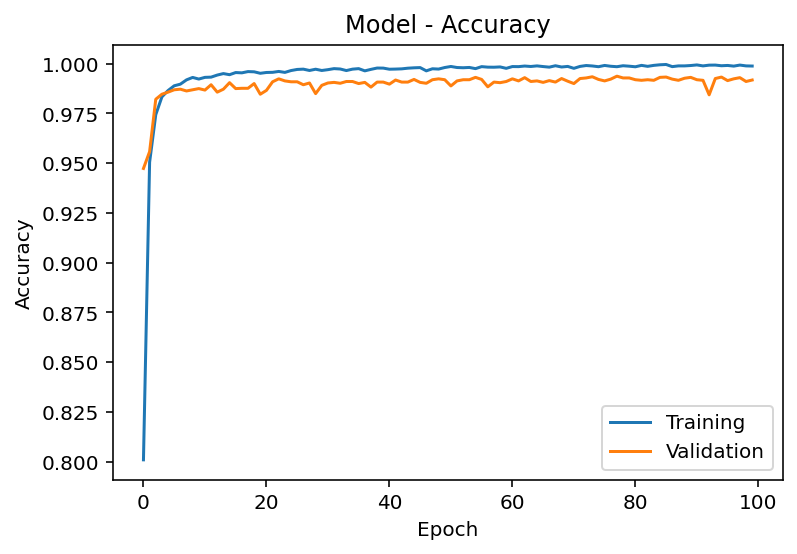

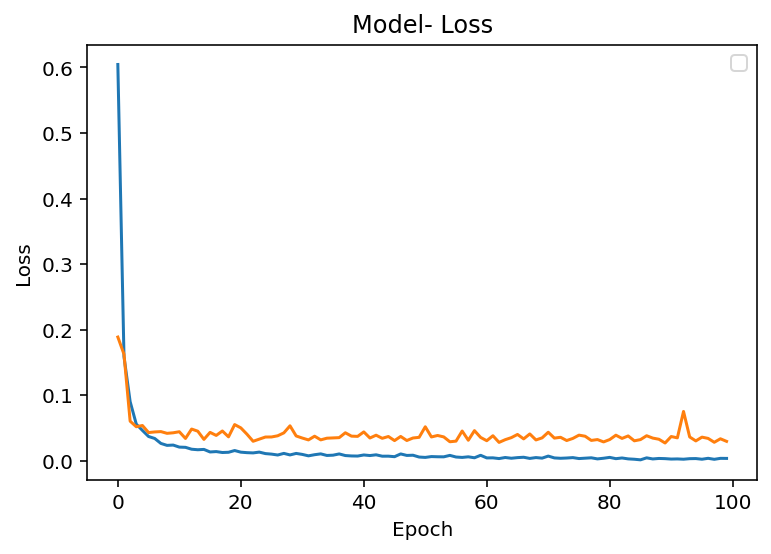

In [32]:
%%time
evaluate_model(history,X_tst_tf,y_tst_oh,qmodel)
y_pred=qmodel.predict(X_tst_tf)

In [33]:
with tf.device('/cpu:0'):
    start = time.time()
    qmodel.predict(X_tst_tf)
    end = time.time()

inference_time =  (end-start)/X_tst_tf.shape[0]
throughput = X_tst_tf.shape[0]/(end-start)

print("Inference on CPU is :", inference_time)
print("Throughput on CPU is :", throughput, "sequence per second")

Inference on CPU is : 0.00038780798973326794
Throughput on CPU is : 2578.5956619609465 sequence per second


In [34]:
with tf.device('/gpu:0'):
    start = time.time()
    qmodel.predict(X_tst_tf)
    end = time.time()

inference_time =  (end-start)/X_tst_tf.shape[0]
throughput = X_tst_tf.shape[0]/(end-start)

print("Inference on GPU is :", inference_time)
print("Throughput on GPU is :", throughput, "sequence per second")

Inference on GPU is : 0.00044499746905458026
Throughput on GPU is : 2247.2037922475174 sequence per second


In [35]:
qmodel.summary()

print_qstats(qmodel)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 319, 1)]          0         
_________________________________________________________________
Qconv1d_1 (QConv1D)          (None, 319, 16)           144       
_________________________________________________________________
q_activation (QActivation)   (None, 319, 16)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 80, 16)            0         
_________________________________________________________________
Qconv1d_2 (QConv1D)          (None, 80, 16)            2064      
_________________________________________________________________
q_activation_1 (QActivation) (None, 80, 16)            0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 20, 16)            0     

# Commented Code
from qkeras.utils import *
model_save_quantized_weights(qmodel, 'qmodel.h5')
#load_qmodel('qmodel.h5', custom_objects=None, compile=True)

In [36]:
from qkeras.utils import *

print_model_sparsity(qmodel)

Model Sparsity Summary (model)
--
Qconv1d_1: (Qconv1d_1/kernel:0, 0.0)
Qconv1d_2: (Qconv1d_2/kernel:0, 0.00732421875)
Qconv1d_3: (Qconv1d_3/kernel:0, 0.00537109375)
OuputLayer: (OuputLayer/kernel:0, 0.004166666666666652)




input                          -11.5861  14.6682
Qconv1d_1                      -18.8488  21.2283

C:\Users\mmorsy\AppData\Roaming\Python\Python38\site-packages\qkeras-0.9.0-py3.8.egg\qkeras\utils.py:994: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\mmorsy\AppData\Roaming\Python\Python38\site-packages\qkeras-0.9.0-py3.8.egg\qkeras\utils.py:1019: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


 ( -0.9922   0.9922) ( -0.9922   0.1016) a(  0.500000   1.000000)
q_activation                     0.0000   0.9961
Qconv1d_2                      -21.3266  11.8937 ( -0.9922   0.9922) ( -0.9844   0.1562) a(  1.000000   1.000000)
q_activation_1                   0.0000   0.9961
Qconv1d_3                      -12.1599  10.3930 ( -0.9922   0.9922) ( -0.8203   0.1719) a(  1.000000   1.000000)
q_activation_2                   0.0000   0.9961
OuputLayer                     -43.4360  20.6705 ( -0.9922   0.9922) ( -0.2344   0.2500) a(  1.000000   1.000000)


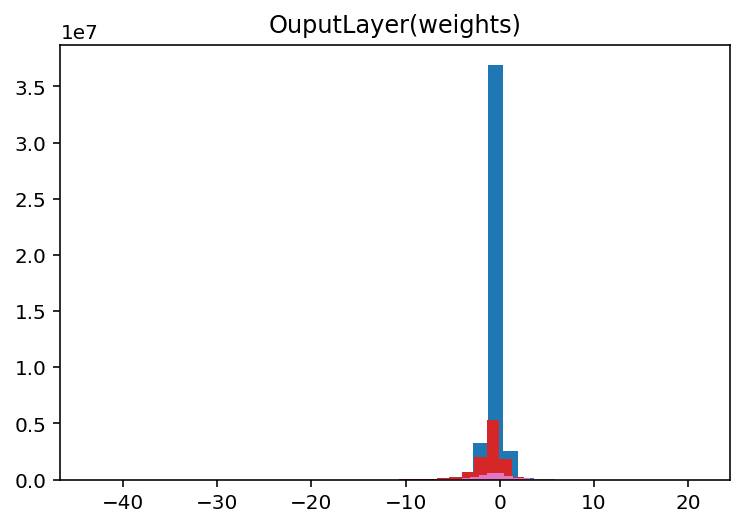

In [37]:
quantized_model_debug(qmodel, X_tst_tf, plot=True)

In [38]:
extract_model_operations(qmodel)

{'Qconv1d_1': {'type': ('mult', (0, 0), (8, 8), (1, 0)),
  'number_of_operations': 40832,
  'number_of_weights': 128,
  'number_of_bias': 16,
  'type_of_weights': (0, 8, 1),
  'type_of_bias': (0, 8, 1)},
 'Qconv1d_2': {'type': ('mult', (0, 0), (8, 8), (1, 0)),
  'number_of_operations': 163840,
  'number_of_weights': 2048,
  'number_of_bias': 16,
  'type_of_weights': (0, 8, 1),
  'type_of_bias': (0, 8, 1)},
 'Qconv1d_3': {'type': ('mult', (0, 0), (8, 8), (1, 0)),
  'number_of_operations': 40960,
  'number_of_weights': 2048,
  'number_of_bias': 16,
  'type_of_weights': (0, 8, 1),
  'type_of_bias': (0, 8, 1)},
 'OuputLayer': {'type': ('mult', (0, 0), (8, 8), (1, 0)),
  'number_of_operations': 1920,
  'number_of_weights': 1920,
  'number_of_bias': 6,
  'type_of_weights': (0, 8, 1),
  'type_of_bias': (0, 8, 1)}}

In [ ]:
_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(qmodel, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

## Prune QKeras Quantized Model

In [52]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_schedule

In [40]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

num_examples = X_trn_tf.shape[0] * (1 - validation_split)
end_step = np.ceil(num_examples / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.90,
                                                               begin_step=0,
                                                               end_step=end_step)
}

pqmodel = prune_low_magnitude(qmodel, **pruning_params)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,
                                                             decay_steps=1000,decay_rate=0.9)
opt = RMSprop(learning_rate=lr_schedule)
    
pqmodel.compile(loss='categorical_crossentropy', optimizer=opt, 
                  metrics=['accuracy'])
pqmodel.summary()

C:\Users\mmorsy\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 319, 1)]          0         
_________________________________________________________________
prune_low_magnitude_Qconv1d_ (None, 319, 16)           274       
_________________________________________________________________
prune_low_magnitude_q_activa (None, 319, 16)           1         
_________________________________________________________________
prune_low_magnitude_max_pool (None, 80, 16)            1         
_________________________________________________________________
prune_low_magnitude_Qconv1d_ (None, 80, 16)            4114      
_________________________________________________________________
prune_low_magnitude_q_activa (None, 80, 16)            1         
_________________________________________________________________
prune_low_magnitude_max_pool (None, 20, 16)            1     

In [41]:
from tempfile import TemporaryDirectory

with TemporaryDirectory() as temp_dir:

    callbacks = [
      tfmot.sparsity.keras.UpdatePruningStep(),
      tfmot.sparsity.keras.PruningSummaries(log_dir=temp_dir),
      EarlyStopping(monitor='val_loss', patience=50),
      ModelCheckpoint(filepath='./int8_pqmodel.h5', 
      monitor='val_accuracy', save_best_only=True)
    ]

    # fit network
    history=pqmodel.fit(X_trn_tf, y_trn_oh, epochs=epochs,callbacks=callbacks, 
                          batch_size=batch_size, validation_split=validation_split,shuffle=True)

pqmodel.load_weights('int8_pqmodel.h5')

train_score = pqmodel.evaluate(X_trn_tf, y_trn_oh)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = pqmodel.evaluate(X_tst_tf, y_tst_oh)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))


Epoch 1/100
 6/54 [==>...........................] - ETA: 29s - loss: 0.0236 - accuracy: 0.9918WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0643s vs `on_train_batch_end` time: 0.4623s). Check your callbacks.


54/54 [==============================] - 23s 210ms/step - loss: 0.0186 - accuracy: 0.9943 - val_loss: 0.0406 - val_accuracy: 0.9906
Epoch 2/100
54/54 [==============================] - 6s 104ms/step - loss: 0.0112 - accuracy: 0.9962 - val_loss: 0.0533 - val_accuracy: 0.9853
Epoch 3/100
54/54 [==============================] - 6s 105ms/step - loss: 0.0218 - accuracy: 0.9927 - val_loss: 0.0405 - val_accuracy: 0.9887
Epoch 4/100
54/54 [==============================] - 6s 104ms/step - loss: 0.0094 - accuracy: 0.9968 - val_loss: 0.0364 - val_accuracy: 0.9899
Epoch 5/100
54/54 [==============================] - 6s 111ms/step - loss: 0.0100 - accuracy: 0.9968 - val_loss: 0.0379 - val_accuracy: 0.9912
Epoch 6/100
54/54 [==============================] - 6s 110ms/step - loss: 0.0082 - accuracy: 0.9974 - val_loss: 0.0367 - val_accuracy: 0.9905
Epoch 7/100
54/54 [==============================] - 6s 113ms/step - loss: 0.0116 - accuracy: 0.9968 - val_loss: 0.0329 - val_accuracy: 0.9914
Epoch 8/10

In [61]:
_, pq_model_accuracy = pqmodel.evaluate(X_tst_tf, y_tst_oh, verbose=0)
print('Pruned test accuracy:', pq_model_accuracy)

Pruned test accuracy: 0.9923845529556274


Accuracy: 99.24%


<ipython-input-6-6945afe0d52d>:13: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
<ipython-input-6-6945afe0d52d>:22: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Wall time: 15.7 s


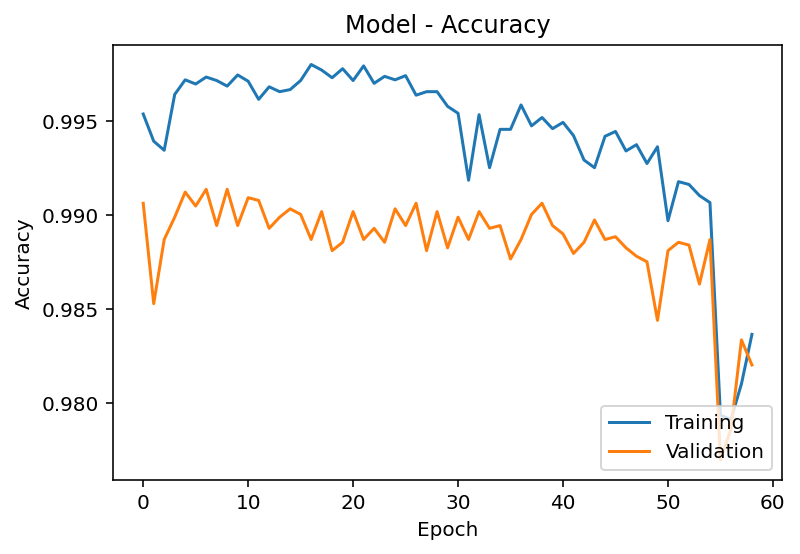

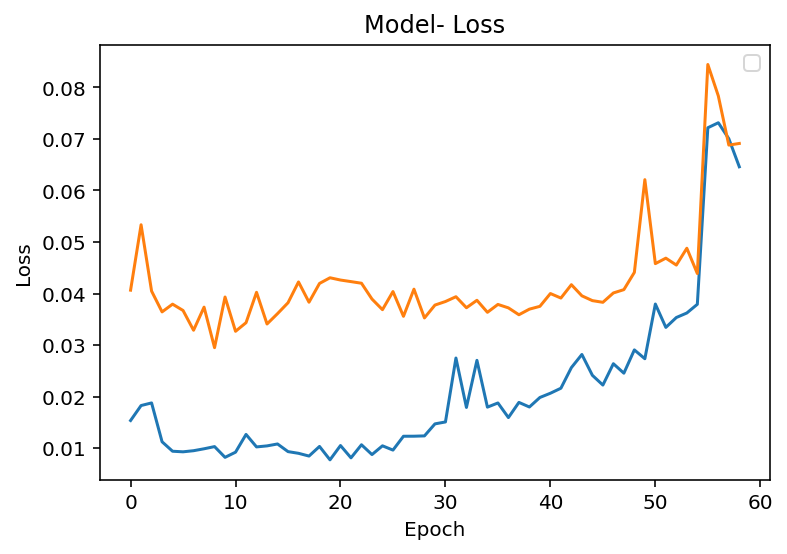

In [42]:
%%time
evaluate_model(history,X_tst_tf,y_tst_oh,pqmodel)
y_pred=pqmodel.predict(X_tst_tf)

In [43]:
with tf.device('/cpu:0'):
    start = time.time()
    pqmodel.predict(X_tst_tf)
    end = time.time()

inference_time =  (end-start)/X_tst_tf.shape[0]
throughput = X_tst_tf.shape[0]/(end-start)

print("Inference on CPU is :", inference_time)
print("Throughput on CPU is :", throughput, "sequence per second")

Inference on CPU is : 0.0004051916092024253
Throughput on CPU is : 2467.9681841595607 sequence per second


In [44]:
with tf.device('/gpu:0'):
    start = time.time()
    pqmodel.predict(X_tst_tf)
    end = time.time()

inference_time =  (end-start)/X_tst_tf.shape[0]
throughput = X_tst_tf.shape[0]/(end-start)

print("Inference on GPU is :", inference_time)
print("Throughput on GPU is :", throughput, "sequence per second")

Inference on GPU is : 0.0006487691249239167
Throughput on GPU is : 1541.3803795260346 sequence per second


In [47]:
pq_model = tfmot.sparsity.keras.strip_pruning(pqmodel)

_, pq_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(pq_model, pq_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pq_keras_file)

Saved pruned Keras model to: C:\Users\mmorsy\AppData\Local\Temp\tmpb_sd6leq.h5


## Convert Pruned Quantized Model to tflite

In [49]:
converter = tf.lite.TFLiteConverter.from_keras_model(pq_model)
pq_tflite_model = converter.convert()

_, pq_tflite_file = tempfile.mkstemp('.tflite')

with open(pq_tflite_file, 'wb') as f:
  f.write(pq_tflite_model)

print('Saved pruned TFLite model to:', pq_tflite_file)

INFO:tensorflow:Assets written to: C:\Users\mmorsy\AppData\Local\Temp\tmp__np8xt5\assets


INFO:tensorflow:Assets written to: C:\Users\mmorsy\AppData\Local\Temp\tmp__np8xt5\assets


Saved pruned TFLite model to: C:\Users\mmorsy\AppData\Local\Temp\tmpfxmfa2qt.tflite


In [56]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [57]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pq_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pq_tflite_file)))

Size of gzipped baseline Keras model: 15638.00 bytes
Size of gzipped pruned Keras model: 15637.00 bytes
Size of gzipped pruned TFlite model: 10275.00 bytes


In [58]:
converter = tf.lite.TFLiteConverter.from_keras_model(pq_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

INFO:tensorflow:Assets written to: C:\Users\mmorsy\AppData\Local\Temp\tmpv0yjanll\assets


INFO:tensorflow:Assets written to: C:\Users\mmorsy\AppData\Local\Temp\tmpv0yjanll\assets


Saved quantized and pruned TFLite model to: C:\Users\mmorsy\AppData\Local\Temp\tmpvs1xl0gj.tflite
Size of gzipped baseline Keras model: 15638.00 bytes
Size of gzipped pruned and quantized TFlite model: 8596.00 bytes


In [59]:
import numpy as np

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on ever y image in the "test" dataset.
  prediction_results = []
  for i, test_example in enumerate(X_tst_tf):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_example = np.expand_dims(test_example, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_example)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_results.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_results)
  accuracy = (prediction_results == y_tst).mean()
  return accuracy

In [62]:
interpreter = tf.lite.Interpreter(model_content=quantized_and_pruned_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('Pruned and quantized TFLite test_accuracy:', test_accuracy)
print('Pruned TF test accuracy:', pq_model_accuracy)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.


Pruned and quantized TFLite test_accuracy: 0.9923845787720134
Pruned TF test accuracy: 0.9923845529556274


In [64]:
def get_flops(model):
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()   

    with graph.as_default():
        with session.as_default():
            model = tf.keras.models.load_model(model)

            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        
            # We use the Keras session graph in the call to the profiler.
            flops = tf.compat.v1.profiler.profile(graph=graph,
                                                  run_meta=run_meta, cmd='op', options=opts)
        
            return flops.total_float_ops

get_flops('base_model.h5')

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


16392